In [1]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import json
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

In [2]:
!gsutil cp gs://financial_fraud_detection/fraud_data_kaggle.csv .

Copying gs://financial_fraud_detection/fraud_data_kaggle.csv...
| [1 files][470.7 MiB/470.7 MiB]   57.7 MiB/s                                   
Operation completed over 1 objects/470.7 MiB.                                    


In [3]:
data = pd.read_csv('fraud_data_kaggle.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
fraud = data[data['isFraud'] == 1]
not_fraud = data[data['isFraud'] == 0]

In [5]:
# Take a random sample of non fraud rows
not_fraud_sample = not_fraud.sample(random_state=2, frac=.005)

# Put it back together and shuffle
df = pd.concat([not_fraud_sample,fraud])
df = shuffle(df, random_state=2)

# Remove a few columns (isFraud is the label column we'll use, not isFlaggedFraud)
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

# Preview the updated dataset
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
5777870,400,PAYMENT,65839.41,0.00,0.00,0.0,0.0,0
6362412,726,TRANSFER,561446.32,561446.32,0.00,0.0,0.0,1
5927827,404,PAYMENT,3828.08,10455.17,6627.09,0.0,0.0,0
5987904,410,TRANSFER,557950.06,557950.06,0.00,0.0,0.0,1
5706694,398,PAYMENT,1376.57,368349.14,366972.57,0.0,0.0,0


In [6]:
train_test_split = int(len(df) * .8)

train_set = df[:train_test_split]
test_set = df[train_test_split:]

train_labels = train_set.pop('isFraud')
test_labels = test_set.pop('isFraud')

In [7]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['type']
NUMERIC_COLUMNS = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [9]:
def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = train_set[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))

In [10]:
NUM_EXAMPLES = len(train_labels)
def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    dataset = dataset.repeat(n_epochs)
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Define training and evaluation input functions
train_input_fn = make_input_fn(train_set, train_labels)
eval_input_fn = make_input_fn(test_set, test_labels, shuffle=False, n_epochs=1)

In [11]:
n_batches = 1
model = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpwlighplj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7eff257cf250>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
The old _FeatureColumn APIs a

In [12]:
model.train(train_input_fn, max_steps=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the ty

In [14]:
result = model.evaluate(eval_input_fn)
print(pd.Series(result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-01T07:19:05Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpwlighplj/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-09-01-07:19:06
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.9943729, accuracy_baseline = 0.8006753, auc = 0.99885267, auc_precision_recall = 0.9973723, average_loss = 0.026979098, global_step = 100, label/mean = 0.19932474, loss = 0.026979098, precision = 0.97544503, prediction/mean = 0.2006575, recall = 0.99686325
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/tmpwlighplj/model.ckpt-100
accuracy                  0.994373
accuracy_baseline         0.800675
auc                       0.998853
auc_precision_recall      0.997372
average_loss              0.026979
label/mean        

In [17]:
pred_dicts = list(model.predict(eval_input_fn))
probabilities = pd.Series([pred['logistic'][0] for pred in pred_dicts])

for i,val in enumerate(probabilities[:30]):
  print('Predicted: ', round(val), 'Actual: ', test_labels.iloc[i])
  print()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpwlighplj/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Predicted:  0 Actual:  0

Predicted:  1 Actual:  1

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  1 Actual:  1

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  1 Actual:  1

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predicted:  0 Actual:  0

Predi

In [18]:
y_pred = []

for i in probabilities.values:
  y_pred.append(int(round(i)))
cm = confusion_matrix(test_labels.values, y_pred)
print(cm)

[[6363   40]
 [   5 1589]]


In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

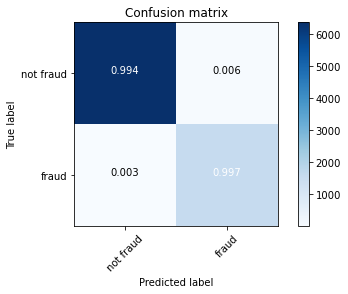

In [20]:
classes = ['not fraud', 'fraud']
plot_confusion_matrix(cm, classes, normalize=True)

In [25]:
# Update these to your own GCP project, model, and version names
GCP_PROJECT = 'MLfrauddetection'
MODEL_BUCKET = 'gs://mlfrauddtectgcp'

In [26]:
!gsutil mb $MODEL_BUCKET

Creating gs://mlfrauddtectgcp/...


In [27]:
def json_serving_input_fn():
  inputs = {}
  for feat in feature_columns:
      if feat.name == "type_indicator":
            inputs['type'] = tf.placeholder(shape=[None], name=feat.name, dtype=tf.string)
      else:
          inputs[feat.name] = tf.placeholder(shape=[None], name=feat.name, dtype=feat.dtype)
  return tf.estimator.export.ServingInputReceiver(inputs, inputs)

In [28]:
export_path = model.export_saved_model(
    MODEL_BUCKET + '/explanations',
    serving_input_receiver_fn=json_serving_input_fn
).decode('utf-8')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:
INFO:tensorflow:'serving_default' : Classification input must be a single string Tensor; got {'type': <tf.Tensor 'type_indicator:0' shape=(?,) dtype=string>, 'step': <tf.Tensor 'step:0' shape=(?,) dtype=float32>, 'amount': <tf.Tensor 'amount:0' shape=(?,) dtype=float32>, 'oldbalanceOrg': <tf.T

In [29]:
def json_serving_input_fn():
  inputs = {}
  for feat in feature_columns:
      if feat.name == "type_indicator":
            inputs['type'] = tf.placeholder(shape=[None], name=feat.name, dtype=tf.string)
      else:
          inputs[feat.name] = tf.placeholder(shape=[None], name=feat.name, dtype=feat.dtype)
  return tf.estimator.export.ServingInputReceiver(inputs, inputs)

In [38]:
MODEL = 'fraud_detectionGCp'
VERSION = 'v1'

In [39]:
!gcloud ai-platform models create $MODEL

Using endpoint [https://ml.googleapis.com/]

Learn more about regional endpoints and see a list of available regions: https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
Created ml engine model [projects/snappy-climber-288206/models/fraud_detectionGCp].


In [ ]:
#Deploy your model
!gcloud beta ai-platform versions create $VERSION \
--model $MODEL \
--origin $export_path \
--runtime-version 1.15 \
--framework TENSORFLOW \
--python-version 3.7 \
--machine-type n1-standard-4 \
--explanation-method 'sampled-shapley' \
--num-paths 10
